In [1]:
import os
import numpy as np
import torch
from pathlib import Path
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

import mne
from mne.io import read_raw_fif

from eegdash.dataset.dataset import EEGChallengeDataset

from braindecode.datasets import BaseDataset, BaseConcatDataset
from braindecode.preprocessing import (
    preprocess, Preprocessor, create_fixed_length_windows,
    exponential_moving_standardize
)
from braindecode.models import SignalJEPA
from braindecode import EEGClassifier
from skorch.helper import predefined_split
from skorch import NeuralNet


In [2]:
DATA_ROOT = Path("LOL_DATASET/HBN_DATA_FULL")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

CACHE_DIR = DATA_ROOT / "R1_mini_L100_bdf"

#### Pretraining Task

In [3]:
TASK_NAMES = [
    "RestingState", "DespicableMe", "DiaryOfAWimpyKid", "FunwithFractals",
    "ThePresent", "contrastChangeDetection", "seqLearning6target",
    "seqLearning8target", "surroundSupp", "symbolSearch"
]


In [4]:
data_total = {}

for task in TASK_NAMES:
    data_task = EEGChallengeDataset(
        cache_dir = str(CACHE_DIR),
        mini = True, 
        task = task, 
        download = False, 
        release = "R1",
        n_jobs = -1
    ) 

    data_total[task] = data_task

╭─────────────────────────────────────── EEG 2025 Competition Data Notice ────────────────────────────────────────╮
│ This object loads the HBN dataset that has been preprocessed for the EEG Challenge:                             │
│   * Downsampled from 500Hz to 100Hz                                                                             │
│   * Bandpass filtered (0.5-50 Hz)                                                                               │
│                                                                                                                 │
│ For full preprocessing applied for competition details, see:                                                    │
│   ]8;id=98;https://github.com/eeg2025/downsample-datasets\https://github.com/eeg2025/downsample-datasets]8;;\                                                                │
│                                                                                                                 │
│ The HBN dataset have some preprocessing applied by the HBN team:                                                │
│   * Re-reference (Cz Channel)                                                                                   │
│                                                                                                                 │
│ IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from ]8;id=245639;https://github.com/sccn/EEGDash/blob/develop/eegdash/api.py\EEGDashDataset]8;;\     │
│ directly.                                                                                                       │
│ If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the    │
│ challenge data.                                                                                                 │
╰────────────────────────────────────────── Source: EEGChallengeDataset ──────────────────────────────────────────╯

╭─────────────────────────────────────── EEG 2025 Competition Data Notice ────────────────────────────────────────╮
│ This object loads the HBN dataset that has been preprocessed for the EEG Challenge:                             │
│   * Downsampled from 500Hz to 100Hz                                                                             │
│   * Bandpass filtered (0.5-50 Hz)                                                                               │
│                                                                                                                 │
│ For full preprocessing applied for competition details, see:                                                    │
│   ]8;id=569046;https://github.com/eeg2025/downsample-datasets\https://github.com/eeg2025/downsample-datasets]8;;\                                                                │
│                                                                                                                 │
│ The HBN dataset have some preprocessing applied by the HBN team:                                                │
│   * Re-reference (Cz Channel)                                                                                   │
│                                                                                                                 │
│ IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from ]8;id=69108;https://github.com/sccn/EEGDash/blob/develop/eegdash/api.py\EEGDashDataset]8;;\     │
│ directly.                                                                                                       │
│ If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the    │
│ challenge data.                                                                                                 │
╰────────────────────────────────────────── Source: EEGChallengeDataset ──────────────────────────────────────────╯

╭─────────────────────────────────────── EEG 2025 Competition Data Notice ────────────────────────────────────────╮
│ This object loads the HBN dataset that has been preprocessed for the EEG Challenge:                             │
│   * Downsampled from 500Hz to 100Hz                                                                             │
│   * Bandpass filtered (0.5-50 Hz)                                                                               │
│                                                                                                                 │
│ For full preprocessing applied for competition details, see:                                                    │
│   ]8;id=149724;https://github.com/eeg2025/downsample-datasets\https://github.com/eeg2025/downsample-datasets]8;;\                                                                │
│                                                                                                                 │
│ The HBN dataset have some preprocessing applied by the HBN team:                                                │
│   * Re-reference (Cz Channel)                                                                                   │
│                                                                                                                 │
│ IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from ]8;id=450130;https://github.com/sccn/EEGDash/blob/develop/eegdash/api.py\EEGDashDataset]8;;\     │
│ directly.                                                                                                       │
│ If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the    │
│ challenge data.                                                                                                 │
╰────────────────────────────────────────── Source: EEGChallengeDataset ──────────────────────────────────────────╯

╭─────────────────────────────────────── EEG 2025 Competition Data Notice ────────────────────────────────────────╮
│ This object loads the HBN dataset that has been preprocessed for the EEG Challenge:                             │
│   * Downsampled from 500Hz to 100Hz                                                                             │
│   * Bandpass filtered (0.5-50 Hz)                                                                               │
│                                                                                                                 │
│ For full preprocessing applied for competition details, see:                                                    │
│   ]8;id=520350;https://github.com/eeg2025/downsample-datasets\https://github.com/eeg2025/downsample-datasets]8;;\                                                                │
│                                                                                                                 │
│ The HBN dataset have some preprocessing applied by the HBN team:                                                │
│   * Re-reference (Cz Channel)                                                                                   │
│                                                                                                                 │
│ IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from ]8;id=862112;https://github.com/sccn/EEGDash/blob/develop/eegdash/api.py\EEGDashDataset]8;;\     │
│ directly.                                                                                                       │
│ If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the    │
│ challenge data.                                                                                                 │
╰────────────────────────────────────────── Source: EEGChallengeDataset ──────────────────────────────────────────╯

╭─────────────────────────────────────── EEG 2025 Competition Data Notice ────────────────────────────────────────╮
│ This object loads the HBN dataset that has been preprocessed for the EEG Challenge:                             │
│   * Downsampled from 500Hz to 100Hz                                                                             │
│   * Bandpass filtered (0.5-50 Hz)                                                                               │
│                                                                                                                 │
│ For full preprocessing applied for competition details, see:                                                    │
│   ]8;id=753021;https://github.com/eeg2025/downsample-datasets\https://github.com/eeg2025/downsample-datasets]8;;\                                                                │
│                                                                                                                 │
│ The HBN dataset have some preprocessing applied by the HBN team:                                                │
│   * Re-reference (Cz Channel)                                                                                   │
│                                                                                                                 │
│ IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from ]8;id=904228;https://github.com/sccn/EEGDash/blob/develop/eegdash/api.py\EEGDashDataset]8;;\     │
│ directly.                                                                                                       │
│ If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the    │
│ challenge data.                                                                                                 │
╰────────────────────────────────────────── Source: EEGChallengeDataset ──────────────────────────────────────────╯

╭─────────────────────────────────────── EEG 2025 Competition Data Notice ────────────────────────────────────────╮
│ This object loads the HBN dataset that has been preprocessed for the EEG Challenge:                             │
│   * Downsampled from 500Hz to 100Hz                                                                             │
│   * Bandpass filtered (0.5-50 Hz)                                                                               │
│                                                                                                                 │
│ For full preprocessing applied for competition details, see:                                                    │
│   ]8;id=139075;https://github.com/eeg2025/downsample-datasets\https://github.com/eeg2025/downsample-datasets]8;;\                                                                │
│                                                                                                                 │
│ The HBN dataset have some preprocessing applied by the HBN team:                                                │
│   * Re-reference (Cz Channel)                                                                                   │
│                                                                                                                 │
│ IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from ]8;id=547531;https://github.com/sccn/EEGDash/blob/develop/eegdash/api.py\EEGDashDataset]8;;\     │
│ directly.                                                                                                       │
│ If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the    │
│ challenge data.                                                                                                 │
╰────────────────────────────────────────── Source: EEGChallengeDataset ──────────────────────────────────────────╯

╭─────────────────────────────────────── EEG 2025 Competition Data Notice ────────────────────────────────────────╮
│ This object loads the HBN dataset that has been preprocessed for the EEG Challenge:                             │
│   * Downsampled from 500Hz to 100Hz                                                                             │
│   * Bandpass filtered (0.5-50 Hz)                                                                               │
│                                                                                                                 │
│ For full preprocessing applied for competition details, see:                                                    │
│   ]8;id=419209;https://github.com/eeg2025/downsample-datasets\https://github.com/eeg2025/downsample-datasets]8;;\                                                                │
│                                                                                                                 │
│ The HBN dataset have some preprocessing applied by the HBN team:                                                │
│   * Re-reference (Cz Channel)                                                                                   │
│                                                                                                                 │
│ IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from ]8;id=973632;https://github.com/sccn/EEGDash/blob/develop/eegdash/api.py\EEGDashDataset]8;;\     │
│ directly.                                                                                                       │
│ If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the    │
│ challenge data.                                                                                                 │
╰────────────────────────────────────────── Source: EEGChallengeDataset ──────────────────────────────────────────╯

╭─────────────────────────────────────── EEG 2025 Competition Data Notice ────────────────────────────────────────╮
│ This object loads the HBN dataset that has been preprocessed for the EEG Challenge:                             │
│   * Downsampled from 500Hz to 100Hz                                                                             │
│   * Bandpass filtered (0.5-50 Hz)                                                                               │
│                                                                                                                 │
│ For full preprocessing applied for competition details, see:                                                    │
│   ]8;id=937428;https://github.com/eeg2025/downsample-datasets\https://github.com/eeg2025/downsample-datasets]8;;\                                                                │
│                                                                                                                 │
│ The HBN dataset have some preprocessing applied by the HBN team:                                                │
│   * Re-reference (Cz Channel)                                                                                   │
│                                                                                                                 │
│ IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from ]8;id=804158;https://github.com/sccn/EEGDash/blob/develop/eegdash/api.py\EEGDashDataset]8;;\     │
│ directly.                                                                                                       │
│ If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the    │
│ challenge data.                                                                                                 │
╰────────────────────────────────────────── Source: EEGChallengeDataset ──────────────────────────────────────────╯

╭─────────────────────────────────────── EEG 2025 Competition Data Notice ────────────────────────────────────────╮
│ This object loads the HBN dataset that has been preprocessed for the EEG Challenge:                             │
│   * Downsampled from 500Hz to 100Hz                                                                             │
│   * Bandpass filtered (0.5-50 Hz)                                                                               │
│                                                                                                                 │
│ For full preprocessing applied for competition details, see:                                                    │
│   ]8;id=694696;https://github.com/eeg2025/downsample-datasets\https://github.com/eeg2025/downsample-datasets]8;;\                                                                │
│                                                                                                                 │
│ The HBN dataset have some preprocessing applied by the HBN team:                                                │
│   * Re-reference (Cz Channel)                                                                                   │
│                                                                                                                 │
│ IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from ]8;id=872743;https://github.com/sccn/EEGDash/blob/develop/eegdash/api.py\EEGDashDataset]8;;\     │
│ directly.                                                                                                       │
│ If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the    │
│ challenge data.                                                                                                 │
╰────────────────────────────────────────── Source: EEGChallengeDataset ──────────────────────────────────────────╯

╭─────────────────────────────────────── EEG 2025 Competition Data Notice ────────────────────────────────────────╮
│ This object loads the HBN dataset that has been preprocessed for the EEG Challenge:                             │
│   * Downsampled from 500Hz to 100Hz                                                                             │
│   * Bandpass filtered (0.5-50 Hz)                                                                               │
│                                                                                                                 │
│ For full preprocessing applied for competition details, see:                                                    │
│   ]8;id=971591;https://github.com/eeg2025/downsample-datasets\https://github.com/eeg2025/downsample-datasets]8;;\                                                                │
│                                                                                                                 │
│ The HBN dataset have some preprocessing applied by the HBN team:                                                │
│   * Re-reference (Cz Channel)                                                                                   │
│                                                                                                                 │
│ IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from ]8;id=881360;https://github.com/sccn/EEGDash/blob/develop/eegdash/api.py\EEGDashDataset]8;;\     │
│ directly.                                                                                                       │
│ If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the    │
│ challenge data.                                                                                                 │
╰────────────────────────────────────────── Source: EEGChallengeDataset ──────────────────────────────────────────╯

In [5]:
print(f"Loaded {sum(len(d.datasets) for d in data_total.values())} subjects.")

Loaded 239 subjects.


In [6]:
# JEPA hyper-parameters
WINDOW_SEC = 30
OVERLAP_RATIO = 0.5

SFREQ = 100.0
N_CHANS = 128

In [ ]:
# Run this on any window
raw = dataset_total.datasets[0].raw

print("Channel names (last 5):")
print(raw.ch_names[-5:])

print("\nChannel types (last 5):")
print(raw.get_channel_types()[-5:])

print(f"\nTotal channels: {len(raw.ch_names)}")

In [7]:
preprocessors = [
    Preprocessor("pick",  picks="eeg"),               # keep only EEG
    Preprocessor("set_eeg_reference", ref_channels="average", ch_type="eeg"),  # FIXED
    Preprocessor(exponential_moving_standardize, 
                 factor_new = 1e-3, 
                 init_block_size = int(10 * SFREQ)
    ),  # 10 sec init block
]


In [8]:
for task in TASK_NAMES:
    data_task = data_total[task]
    print(f"Preprocessing task: {task} with {len(data_task.datasets)} subjects.")

Preprocessing task: RestingState with 20 subjects.
Preprocessing task: DespicableMe with 20 subjects.
Preprocessing task: DiaryOfAWimpyKid with 20 subjects.
Preprocessing task: FunwithFractals with 20 subjects.
Preprocessing task: ThePresent with 20 subjects.
Preprocessing task: contrastChangeDetection with 60 subjects.
Preprocessing task: seqLearning6target with 8 subjects.
Preprocessing task: seqLearning8target with 11 subjects.
Preprocessing task: surroundSupp with 40 subjects.
Preprocessing task: symbolSearch with 20 subjects.


In [9]:
len(data_total['RestingState'].datasets)

20

In [10]:
data_total['RestingState'].datasets[0].description

subject                      NDARAC904DMU
task                         RestingState
age                               11.3386
sex                                     F
release_number                         R1
ehq_total                           71.17
commercial_use                        Yes
full_pheno                            Yes
p_factor                           -0.603
attention                          -0.446
internalizing                       1.248
externalizing                       0.325
restingstate                    available
despicableme                    available
funwithfractals                 available
thepresent                      available
diaryofawimpykid                available
contrastchangedetection_1       available
contrastchangedetection_2       available
contrastchangedetection_3       available
surroundsupp_1                  available
surroundsupp_2                  available
seqlearning6target            unavailable
seqlearning8target              av

Preprocess and save each task

In [11]:
all_preproc_datasets = []

SAVE_DIR = CACHE_DIR / "preprocessed"
SAVE_DIR.mkdir(parents=True, exist_ok=True)
print(SAVE_DIR)

for task in TASK_NAMES:
    dataset = data_total[task]
    task_save_dir = SAVE_DIR / task
    task_save_dir.mkdir(exist_ok=True)

    print(task_save_dir)

    print(f"\n[PREPROCESS] {task} → {len(dataset.datasets)} subjects")

    # # --- Preload all raws ---
    for ds in dataset.datasets:
        if not ds.raw.preload:
            ds.raw.load_data()

    # --- Apply preprocessing ---
    preproc_dataset = preprocess(
        dataset,
        preprocessors,
        save_dir = task_save_dir,
        n_jobs = -1,
        overwrite = True
    )

    # --- Reload preprocessed raws into BaseDataset ---
    raw_paths = sorted(task_save_dir.rglob("*-raw.fif"))
    print(f"  → Found & loading {len(raw_paths)} preprocessed files")

    for raw_path in raw_paths:
        try:
            raw = read_raw_fif(raw_path, preload=True, verbose=False)
            description = {
                "task": task,
                "subject": raw_path.parent.name,
                "filename": raw_path.name
            }
            all_preproc_datasets.append(BaseDataset(raw, description))
        except Exception as e:
            print(f"  [ERROR] Failed to load {raw_path}: {e}")


LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed
LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState

[PREPROCESS] RestingState → 20 subjects
Reading 0 ... 40399  =      0.000 ...   403.990 secs...
Reading 0 ... 34599  =      0.000 ...   345.990 secs...
Reading 0 ... 37799  =      0.000 ...   377.990 secs...
Reading 0 ... 42899  =      0.000 ...   428.990 secs...
Reading 0 ... 41399  =      0.000 ...   413.990 secs...
Reading 0 ... 35199  =      0.000 ...   351.990 secs...
Reading 0 ... 34699  =      0.000 ...   346.990 secs...
Reading 0 ... 37899  =      0.000 ...   378.990 secs...
Reading 0 ... 36899  =      0.000 ...   368.990 secs...
Reading 0 ... 41399  =      0.000 ...   413.990 secs...
Reading 0 ... 40999  =      0.000 ...   409.990 secs...
Reading 0 ... 46299  =      0.000 ...   462.990 secs...
Reading 0 ... 41099  =      0.000 ...   410.990 secs...
Reading 0 ... 39399  =      0.000 ...   393.990 secs...
Reading 0 ... 38199  =      0.000 ...   381.990 se

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (7) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState contains other subdirectories or files ['11', '8', '4', '3', '2', '15', '10', '18', '1', '14', '5', '19', '17', '12', '13', '7', '16', '9', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (3) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packa

Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState/10/10-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState/4/4-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState/9/9-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState/15/15-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState/5/5-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState/0/0-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState/16/16-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState/3/3-raw.fif
[don

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (6) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState contains other subdirectories or files ['11', '8', '4', '3', '2', '15', '10', '18', '1', '14', '19', '17', '12', '6', '13', '7', '16', '9', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (4) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packa

Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState/13/13-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState/12/12-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState/19/19-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState/11/11-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState/12/12-raw.fif
[done]
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState/19/19-raw.fif
[done]
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState/11/11-raw.fif
[done]


/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (14) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState contains other subdirectories or files ['11', '8', '4', '3', '2', '15', '10', '18', '1', '14', '5', '19', '17', '12', '6', '7', '16', '9', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (13) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-pack

Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState/0/0-raw.fif...
Isotrak not found
    Range : 0 ... 40399 =      0.000 ...   403.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState/1/1-raw.fif...
Isotrak not found
    Range : 0 ... 34599 =      0.000 ...   345.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState/2/2-raw.fif...
Isotrak not found
    Range : 0 ... 37799 =      0.000 ...   377.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState/3/3-raw.fif...
Isotrak not found
    Range : 0 ... 42899 =      0.000 ...   428.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/RestingState/4/4-raw.fif...
Isotrak not found
    Range : 0 ... 41399 =      0.000 ...   413.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (11) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe contains other subdirectories or files ['11', '8', '4', '3', '2', '15', '18', '1', '14', '5', '19', '17', '12', '6', '13', '7', '16', '9', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (19) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-pack

Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe/6/6-raw.fif
[done]
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe/13/13-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe/1/1-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe/4/4-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe/15/15-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe/8/8-r

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (14) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe contains other subdirectories or files ['11', '8', '4', '3', '2', '15', '10', '18', '1', '14', '5', '19', '17', '12', '6', '7', '16', '9', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (2) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packa

Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe/7/7-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe/3/3-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe/3/3-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe/9/9-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe/11/11-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe/2/2-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe/19/19-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe/9/9-raw.fif
[done]

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (3) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe contains other subdirectories or files ['11', '8', '4', '3', '15', '10', '18', '1', '14', '5', '19', '17', '12', '6', '13', '7', '16', '9', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe contains other subdirectories or files ['11', '8', '4', '3', '2', '15', '10', '18', '1', '14', '5', '17', '12', '6', '13', '7', '16', '9', '0'].
  warn

Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe/16/16-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe/16/16-raw.fif
[done]
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe/0/0-raw.fif...
Isotrak not found
    Range : 0 ... 17299 =      0.000 ...   172.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe/1/1-raw.fif...
Isotrak not found
    Range : 0 ... 17299 =      0.000 ...   172.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe/2/2-raw.fif...
Isotrak not found
    Range : 0 ... 17399 =      0.000 ...   173.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DespicableMe/3/3-raw.fif...
Isotrak not found
    Range : 0 ... 17599 =      0.000 ...   175.990 secs
Read

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (12) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DiaryOfAWimpyKid contains other subdirectories or files ['8', '4', '3', '2', '15', '10', '18', '1', '14', '5', '19', '17', '12', '6', '13', '7', '16', '9', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (9) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-p

Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DiaryOfAWimpyKid/0/0-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DiaryOfAWimpyKid/0/0-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DiaryOfAWimpyKid/6/6-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/pre

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (1) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DiaryOfAWimpyKid contains other subdirectories or files ['11', '8', '4', '3', '2', '15', '10', '18', '1', '14', '5', '19', '17', '12', '6', '13', '7', '16', '9'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (7) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-p

Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DiaryOfAWimpyKid/1/1-raw.fif...
Isotrak not found
    Range : 0 ... 11899 =      0.000 ...   118.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DiaryOfAWimpyKid/2/2-raw.fif...
Isotrak not found
    Range : 0 ... 11899 =      0.000 ...   118.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DiaryOfAWimpyKid/3/3-raw.fif...
Isotrak not found
    Range : 0 ... 12299 =      0.000 ...   122.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DiaryOfAWimpyKid/4/4-raw.fif...
Isotrak not found
    Range : 0 ... 11899 =      0.000 ...   118.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/DiaryOfAWimpyKid/5/5-raw.fif...
Isotrak not found
    Range : 0 ... 11899 =      0.000 ...   118.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FU

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (2) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/FunwithFractals contains other subdirectories or files ['11', '8', '4', '3', '2', '15', '10', '18', '14', '5', '19', '17', '12', '6', '13', '7', '16', '9', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (3) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-pa

Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/FunwithFractals/19/19-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/FunwithFractals/17/17-raw.fif
[done]
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/FunwithFractals/18/18-raw.fif
[done]
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/FunwithFractals/19/19-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/FunwithFractals/16/16-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/FunwithFractals/16/16-raw.fif
[done]


/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (19) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/FunwithFractals contains other subdirectories or files ['11', '8', '4', '3', '2', '15', '10', '1', '14', '5', '19', '17', '12', '6', '13', '7', '16', '9', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/FunwithFractals contains other subdirectories or files ['11', '8', '4', '3', '2', '15', '10', '18', '1', '14', '5', '17', '12', '6', '13', '7', '16', '9', '0'].


Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/FunwithFractals/0/0-raw.fif...
Isotrak not found
    Range : 0 ... 16499 =      0.000 ...   164.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/FunwithFractals/1/1-raw.fif...
Isotrak not found
    Range : 0 ... 16599 =      0.000 ...   165.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/FunwithFractals/2/2-raw.fif...
Isotrak not found
    Range : 0 ... 16599 =      0.000 ...   165.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/FunwithFractals/3/3-raw.fif...
Isotrak not found
    Range : 0 ... 16799 =      0.000 ...   167.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/FunwithFractals/4/4-raw.fif...
Isotrak not found
    Range : 0 ... 16599 =      0.000 ...   165.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (2) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/ThePresent contains other subdirectories or files ['11', '8', '4', '3', '2', '15', '10', '18', '14', '5', '19', '17', '12', '6', '13', '7', '16', '9', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (1) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-package

Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/ThePresent/4/4-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/ThePresent/8/8-raw.fif
Applying average reference.
Applying a custom ('EEG',) reference.
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/ThePresent/9/9-raw.fif
[done]
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/ThePresent/10/10-raw.fif
Applying average reference.
Applying a custom ('EEG',) reference.
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/ThePresent/8/8-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/ThePresent/12/12-raw.fif
Applying average reference.
Applying a custom ('EEG',) re

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (9) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/ThePresent contains other subdirectories or files ['11', '4', '3', '2', '15', '10', '18', '1', '14', '5', '19', '17', '12', '6', '13', '7', '16', '9', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (13) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packag

Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/ThePresent/19/19-raw.fif
[done]
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/ThePresent/0/0-raw.fif...
Isotrak not found
    Range : 0 ... 20599 =      0.000 ...   205.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/ThePresent/1/1-raw.fif...
Isotrak not found
    Range : 0 ... 20499 =      0.000 ...   204.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/ThePresent/2/2-raw.fif...
Isotrak not found
    Range : 0 ... 20499 =      0.000 ...   204.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/ThePresent/3/3-raw.fif...
Isotrak not found
    Range : 0 ... 20799 =      0.000 ...   207.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/ThePresent/4/4-raw.fif...
Isotrak not found
    Range

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/ThePresent contains other subdirectories or files ['11', '8', '4', '3', '2', '15', '10', '18', '1', '14', '5', '17', '12', '6', '13', '7', '16', '9', '0'].
  warnings.warn(


Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/ThePresent/10/10-raw.fif...
Isotrak not found
    Range : 0 ... 20499 =      0.000 ...   204.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/ThePresent/11/11-raw.fif...
Isotrak not found
    Range : 0 ... 20499 =      0.000 ...   204.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/ThePresent/12/12-raw.fif...
Isotrak not found
    Range : 0 ... 20899 =      0.000 ...   208.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/ThePresent/13/13-raw.fif...
Isotrak not found
    Range : 0 ... 20899 =      0.000 ...   208.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/ThePresent/14/14-raw.fif...
Isotrak not found
    Range : 0 ... 20599 =      0.000 ...   205.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (1) does not match the number of existing subdirectories (60). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection contains other subdirectories or files ['11', '8', '4', '3', '24', '44', '2', '29', '28', '54', '15', '38', '35', '37', '41', '10', '18', '21', '59', '1', '56', '51', '43', '14', '55', '22', '5', '57', '30', '26', '34', '58', '45', '19', '27', '53', '47', '32', '52', '42', '17', '50', '23', '12', '6', '13', '20', '7', '46', '48', '39', '36', '33', '16', '25', '40', '9', '31', '49'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778:

[done]
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/3/3-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/8/8-raw.fif
Applying average reference.
Applying a custom ('EEG',) reference.
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/8/8-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/6/6-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/9/9-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/3/

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (6) does not match the number of existing subdirectories (60). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection contains other subdirectories or files ['11', '8', '4', '3', '24', '44', '2', '29', '28', '54', '15', '38', '35', '37', '41', '10', '18', '21', '59', '1', '56', '51', '43', '14', '55', '22', '57', '30', '26', '34', '58', '45', '19', '27', '53', '47', '32', '52', '42', '17', '50', '23', '12', '6', '13', '20', '7', '46', '48', '39', '36', '33', '16', '25', '40', '9', '31', '0', '49'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778:

Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/9/9-raw.fif
Applying average reference.
Applying a custom ('EEG',) reference.
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/7/7-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/6/6-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/11/11-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/4/4-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/11/11-raw.fif
[done]
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (10) does not match the number of existing subdirectories (60). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection contains other subdirectories or files ['11', '8', '4', '3', '24', '44', '2', '29', '28', '54', '15', '38', '35', '37', '41', '10', '18', '21', '59', '1', '56', '51', '43', '14', '55', '22', '5', '57', '30', '26', '34', '58', '45', '19', '27', '53', '47', '32', '52', '42', '17', '50', '23', '12', '6', '13', '20', '7', '46', '48', '39', '36', '33', '16', '25', '40', '31', '0', '49'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778

Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/10/10-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/12/12-raw.fif
[done]
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/17/17-raw.fif
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/15/15-raw.fif
Applying average reference.
Applying a custom ('EEG',) reference.
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/10/10-raw.fif
[done]
Closing /home/ubuntu/quang/eeg_challenge/LOL_DA

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (13) does not match the number of existing subdirectories (60). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection contains other subdirectories or files ['11', '8', '4', '3', '24', '44', '2', '29', '28', '54', '15', '38', '35', '37', '41', '10', '18', '21', '59', '1', '56', '51', '43', '14', '55', '22', '5', '57', '30', '26', '34', '58', '45', '19', '27', '53', '47', '32', '52', '42', '17', '50', '23', '6', '13', '20', '7', '46', '48', '39', '36', '33', '16', '25', '40', '9', '31', '0', '49'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778:

Applying average reference.
Applying a custom ('EEG',) reference.
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/18/18-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/15/15-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/19/19-raw.fif
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/20/20-raw.fif
Applying average reference.
Applying a custom ('EEG',) reference.
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/18/18-raw.fif
[done]
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDe

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (16) does not match the number of existing subdirectories (60). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection contains other subdirectories or files ['11', '8', '4', '3', '24', '44', '2', '29', '28', '54', '38', '35', '37', '41', '10', '18', '21', '59', '1', '56', '51', '43', '14', '55', '22', '5', '57', '30', '26', '34', '58', '45', '19', '27', '53', '47', '32', '52', '42', '17', '50', '23', '12', '6', '13', '20', '7', '46', '48', '39', '36', '33', '16', '25', '40', '9', '31', '0', '49'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778:

Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/23/23-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/26/26-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/21/21-raw.fif
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/23/23-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/22/22-raw.fif
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom (

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (24) does not match the number of existing subdirectories (60). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection contains other subdirectories or files ['11', '8', '4', '3', '24', '44', '2', '29', '28', '54', '15', '38', '35', '37', '41', '10', '18', '21', '59', '1', '56', '51', '43', '14', '55', '22', '5', '57', '30', '26', '34', '58', '45', '19', '27', '53', '47', '32', '52', '42', '17', '50', '12', '6', '13', '20', '7', '46', '48', '39', '36', '33', '16', '25', '40', '9', '31', '0', '49'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778:

Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/31/31-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/16/16-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/22/22-raw.fif
[done]
Applying average reference.
Applying a custom ('EEG',) reference.
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/24/24-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/34/34-raw.fif
Applying average reference.
Applying a custom ('EEG',) reference.
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/31/31-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challe

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (25) does not match the number of existing subdirectories (60). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection contains other subdirectories or files ['11', '8', '4', '3', '44', '2', '29', '28', '54', '15', '38', '35', '37', '41', '10', '18', '21', '59', '1', '56', '51', '43', '14', '55', '22', '5', '57', '30', '26', '34', '58', '45', '19', '27', '53', '47', '32', '52', '42', '17', '50', '23', '12', '6', '13', '20', '7', '46', '48', '39', '36', '33', '16', '25', '40', '9', '31', '0', '49'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778:

Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/25/25-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/33/33-raw.fif
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/30/30-raw.fif
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/39/39-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/41/41-raw.fif
Applying average reference.
Applying a custom ('EEG',)

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (34) does not match the number of existing subdirectories (60). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection contains other subdirectories or files ['11', '8', '4', '3', '24', '44', '2', '29', '28', '54', '15', '38', '35', '37', '41', '10', '18', '21', '59', '1', '56', '51', '43', '14', '55', '22', '5', '57', '30', '26', '34', '58', '45', '19', '27', '53', '47', '32', '52', '42', '17', '50', '23', '12', '6', '13', '20', '7', '46', '48', '39', '36', '16', '25', '40', '9', '31', '0', '49'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778:

Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/46/46-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/42/42-raw.fif
[done]
Applying average reference.
Applying a custom ('EEG',) reference.
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/45/45-raw.fif
[done]
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/47/47-raw.fif
[done]
Applying average reference.
Applying a custom ('EEG',) reference.
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/36/36-raw.fif
[done]
Applying average reference.
Apply

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (43) does not match the number of existing subdirectories (60). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection contains other subdirectories or files ['11', '8', '4', '3', '24', '44', '2', '29', '28', '54', '15', '38', '35', '37', '41', '10', '18', '21', '59', '1', '56', '51', '43', '14', '55', '22', '5', '57', '30', '26', '34', '58', '45', '19', '27', '53', '47', '32', '52', '17', '50', '23', '12', '6', '13', '20', '7', '46', '48', '39', '36', '33', '16', '25', '40', '9', '31', '0', '49'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778:

Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/43/43-raw.fif
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/48/48-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/51/51-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/52/52-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/37/37-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/53/53-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetect

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (38) does not match the number of existing subdirectories (60). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection contains other subdirectories or files ['11', '8', '4', '3', '24', '44', '2', '29', '28', '54', '15', '38', '35', '41', '10', '18', '21', '59', '1', '56', '51', '43', '14', '55', '22', '5', '57', '30', '26', '34', '58', '45', '19', '27', '53', '47', '32', '52', '42', '17', '50', '23', '12', '6', '13', '20', '7', '46', '48', '39', '36', '33', '16', '25', '40', '9', '31', '0', '49'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778:

Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/57/57-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/56/56-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/59/59-raw.fif
[done]
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/54/54-raw.fif
[done]
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/58/58-raw.fif
[done]
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/50/50-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/49/49-raw.fif
Closing /home/ubuntu

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (57) does not match the number of existing subdirectories (60). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection contains other subdirectories or files ['11', '8', '4', '3', '24', '44', '2', '29', '28', '54', '15', '38', '35', '37', '41', '10', '18', '21', '59', '1', '51', '43', '14', '55', '22', '5', '57', '30', '26', '34', '58', '45', '19', '27', '53', '47', '32', '52', '42', '17', '50', '23', '12', '6', '13', '20', '7', '46', '48', '39', '36', '33', '16', '25', '40', '9', '31', '0', '49'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778:

Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/49/49-raw.fif
[done]
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/0/0-raw.fif...
Isotrak not found
    Range : 0 ... 23499 =      0.000 ...   234.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/1/1-raw.fif...
Isotrak not found
    Range : 0 ... 23899 =      0.000 ...   238.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/2/2-raw.fif...
Isotrak not found
    Range : 0 ... 24099 =      0.000 ...   240.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/contrastChangeDetection/3/3-raw.fif...
Isotrak not found
    Range : 0 ... 42799 =      0.000 ...   427.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/p

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (2) does not match the number of existing subdirectories (8). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/seqLearning6target contains other subdirectories or files ['4', '3', '2', '5', '6', '7', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (6) does not match the number of existing subdirectories (8). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen director

Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/seqLearning6target/6/6-raw.fif
[done]
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/seqLearning6target/0/0-raw.fif
[done]
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/seqLearning6target/0/0-raw.fif...
Isotrak not found
    Range : 0 ... 48299 =      0.000 ...   482.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/seqLearning6target/1/1-raw.fif...
Isotrak not found
    Range : 0 ... 20699 =      0.000 ...   206.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/seqLearning6target/2/2-raw.fif...
Isotrak not found
    Range : 0 ... 37499 =      0.000 ...   374.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/seqLearning6target/3/3-raw.fif...
Isotrak not found
    Range : 0 ... 270

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (2) does not match the number of existing subdirectories (11). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/seqLearning8target contains other subdirectories or files ['8', '4', '3', '2', '10', '5', '6', '7', '9', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (3) does not match the number of existing subdirectories (11). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarnin

Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/seqLearning8target/10/10-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/seqLearning8target/9/9-raw.fif
[done]
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/seqLearning8target/10/10-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/seqLearning8target/6/6-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/seqLearning8target/6/6-raw.fif
[done]


/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/seqLearning8target contains other subdirectories or files ['8', '4', '3', '2', '1', '5', '6', '7', '9', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (7) does not match the number of existing subdirectories (11). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/seqLearning8target contains other subdirectories or files ['8', '4', '3', '2', '10', '1', '5', '7', '9', '0'].
  warnings.warn(


Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/seqLearning8target/0/0-raw.fif...
Isotrak not found
    Range : 0 ... 46399 =      0.000 ...   463.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/seqLearning8target/1/1-raw.fif...
Isotrak not found
    Range : 0 ... 33299 =      0.000 ...   332.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/seqLearning8target/2/2-raw.fif...
Isotrak not found
    Range : 0 ... 30899 =      0.000 ...   308.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/seqLearning8target/3/3-raw.fif...
Isotrak not found
    Range : 0 ... 29399 =      0.000 ...   293.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/seqLearning8target/4/4-raw.fif...
Isotrak not found
    Range : 0 ... 33399 =      0.000 ...   333.990 secs
Ready.
Opening raw data file LOL_DATASET/H

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (1) does not match the number of existing subdirectories (40). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp contains other subdirectories or files ['11', '8', '4', '3', '24', '2', '29', '28', '15', '38', '35', '37', '10', '18', '21', '1', '14', '22', '5', '30', '26', '34', '19', '27', '32', '17', '23', '12', '6', '13', '20', '7', '39', '36', '33', '16', '25', '9', '31'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (3) does not match the number of existing subdirectories (40). You may now encounter a m

Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/5/5-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/6/6-raw.fif
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/8/8-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/5/5-raw.fif
[done]
Applying average reference.
Applying a custom ('EEG',) reference.
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/6/6-raw.fif
[done]
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/8/

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (6) does not match the number of existing subdirectories (40). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp contains other subdirectories or files ['11', '8', '4', '3', '24', '2', '29', '28', '15', '38', '35', '37', '10', '18', '21', '1', '14', '22', '30', '26', '34', '19', '27', '32', '17', '23', '12', '6', '13', '20', '7', '39', '36', '33', '16', '25', '9', '31', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (7) does not match the number of existing subdirectories (40). You may now encounter a m

Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/10/10-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/9/9-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/7/7-raw.fif
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/12/12-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/16/16-raw.fif
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundS

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (13) does not match the number of existing subdirectories (40). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp contains other subdirectories or files ['11', '8', '4', '3', '24', '2', '29', '28', '15', '38', '35', '37', '10', '18', '21', '1', '14', '22', '5', '30', '26', '34', '19', '27', '32', '17', '23', '6', '13', '20', '7', '39', '36', '33', '16', '25', '9', '31', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (10) does not match the number of existing subdirectories (40). You may now encounter a 

Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/14/14-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/20/20-raw.fif
Applying average reference.
Applying a custom ('EEG',) reference.
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/11/11-raw.fif
[done]
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/13/13-raw.fif
[done]
Applying average reference.
Applying a custom ('EEG',) reference.
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/20/20-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/18/18-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surrou

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (12) does not match the number of existing subdirectories (40). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp contains other subdirectories or files ['8', '4', '3', '24', '2', '29', '28', '15', '38', '35', '37', '10', '18', '21', '1', '14', '22', '5', '30', '26', '34', '19', '27', '32', '17', '23', '12', '6', '13', '20', '7', '39', '36', '33', '16', '25', '9', '31', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (14) does not match the number of existing subdirectories (40). You may now encounter a 

Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/21/21-raw.fif
Applying average reference.
Applying a custom ('EEG',) reference.
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/15/15-raw.fif
[done]
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/19/19-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/24/24-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/23/23-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/21/21-raw.fif
[done]
Applying average reference.
Applying a custo

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (22) does not match the number of existing subdirectories (40). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp contains other subdirectories or files ['11', '8', '4', '3', '24', '2', '29', '28', '15', '38', '35', '37', '10', '18', '1', '14', '22', '5', '30', '26', '34', '19', '27', '32', '17', '23', '12', '6', '13', '20', '7', '39', '36', '33', '16', '25', '9', '31', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (25) does not match the number of existing subdirectories (40). You may now encounter a 

Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/32/32-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/27/27-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/34/34-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/29/29-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/25/25-raw.fif
[done]
Applying average reference.
Applying a custom ('EEG',) reference.
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/32/32-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (26) does not match the number of existing subdirectories (40). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp contains other subdirectories or files ['11', '8', '4', '3', '24', '2', '29', '28', '15', '38', '35', '37', '10', '18', '21', '1', '14', '22', '5', '30', '26', '34', '19', '27', '32', '17', '23', '12', '6', '13', '20', '7', '39', '36', '33', '16', '9', '31', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (33) does not match the number of existing subdirectories (40). You may now encounter a 

Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/38/38-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/33/33-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/36/36-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/35/35-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/37/37-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/39/39-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/35/35-raw.fif
[done]
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/3

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (36) does not match the number of existing subdirectories (40). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp contains other subdirectories or files ['11', '8', '4', '3', '24', '2', '29', '28', '15', '38', '37', '10', '18', '21', '1', '14', '22', '5', '30', '26', '34', '19', '27', '32', '17', '23', '12', '6', '13', '20', '7', '39', '36', '33', '16', '25', '9', '31', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (34) does not match the number of existing subdirectories (40). You may now encounter a 

Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/0/0-raw.fif...
Isotrak not found
    Range : 0 ... 29399 =      0.000 ...   293.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/1/1-raw.fif...
Isotrak not found
    Range : 0 ... 48699 =      0.000 ...   486.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/2/2-raw.fif...
Isotrak not found
    Range : 0 ... 28399 =      0.000 ...   283.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/3/3-raw.fif...
Isotrak not found
    Range : 0 ... 48399 =      0.000 ...   483.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/surroundSupp/4/4-raw.fif...
Isotrak not found
    Range : 0 ... 29499 =      0.000 ...   294.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (1) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/symbolSearch contains other subdirectories or files ['11', '8', '4', '3', '2', '15', '10', '18', '1', '14', '5', '19', '17', '12', '6', '13', '7', '16', '9'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (3) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packa

Applying average reference.
Applying a custom ('EEG',) reference.
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/symbolSearch/10/10-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/symbolSearch/14/14-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/symbolSearch/11/11-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/symbolSearch/13/13-raw.fif
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/symbolSearch/15/15-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/symbolSearch/12/12-raw.fif
[done]
Writing /home/ubuntu/quang/eeg_challenge/LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/symbolSearch/1/1-raw.fif
Closing /home/ubuntu/quang/eeg_challenge/LOL_DA

/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (11) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:789: UserWarning: Chosen directory LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/symbolSearch contains other subdirectories or files ['11', '8', '4', '3', '2', '15', '18', '1', '14', '5', '19', '17', '12', '6', '13', '7', '16', '9', '0'].
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-packages/braindecode/datasets/base.py:778: UserWarning: The number of saved datasets (12) does not match the number of existing subdirectories (20). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(
/home/ubuntu/miniconda3/envs/eeg_new/lib/python3.11/site-pack

Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/symbolSearch/0/0-raw.fif...
Isotrak not found
    Range : 0 ... 15699 =      0.000 ...   156.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/symbolSearch/1/1-raw.fif...
Isotrak not found
    Range : 0 ... 51199 =      0.000 ...   511.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/symbolSearch/2/2-raw.fif...
Isotrak not found
    Range : 0 ... 16699 =      0.000 ...   166.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/symbolSearch/3/3-raw.fif...
Isotrak not found
    Range : 0 ... 19499 =      0.000 ...   194.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/preprocessed/symbolSearch/4/4-raw.fif...
Isotrak not found
    Range : 0 ... 17099 =      0.000 ...   170.990 secs
Ready.
Opening raw data file LOL_DATASET/HBN_DATA_FULL/R1_mini_L100_bdf/

In [12]:
len(all_preproc_datasets)

239

In [13]:
# --- FINAL: Concatenate all into one big dataset ---
concat_preproc = BaseConcatDataset(all_preproc_datasets)
print(f"BaseConcatDataset created with {len(concat_preproc.datasets)} recordings.")

BaseConcatDataset created with 239 recordings.


### Visualization of the dataset

In [14]:
# --- 2. Extract the first Raw ---
first_raw = concat_preproc.datasets[0].raw
description = concat_preproc.datasets[0].description

print(f"\nFirst recording:")
print(f"   Task: {description.get('task', 'unknown')}")
print(f"   Subject: {description.get('subject', 'unknown')}")
print(f"   Duration: {first_raw.n_times / first_raw.info['sfreq']:.1f} sec")
print(f"   Channels: {len(first_raw.ch_names)} EEG")
print(f"   Mean: {first_raw.get_data().mean():.2e}")
print(f"   Std:  {first_raw.get_data().std():.3f}")


First recording:
   Task: RestingState
   Subject: 0
   Duration: 404.0 sec
   Channels: 129 EEG
   Mean: -8.02e-04
   Std:  0.431



Opening interactive MNE plot... (close to continue)
Using matplotlib as 2D backend.


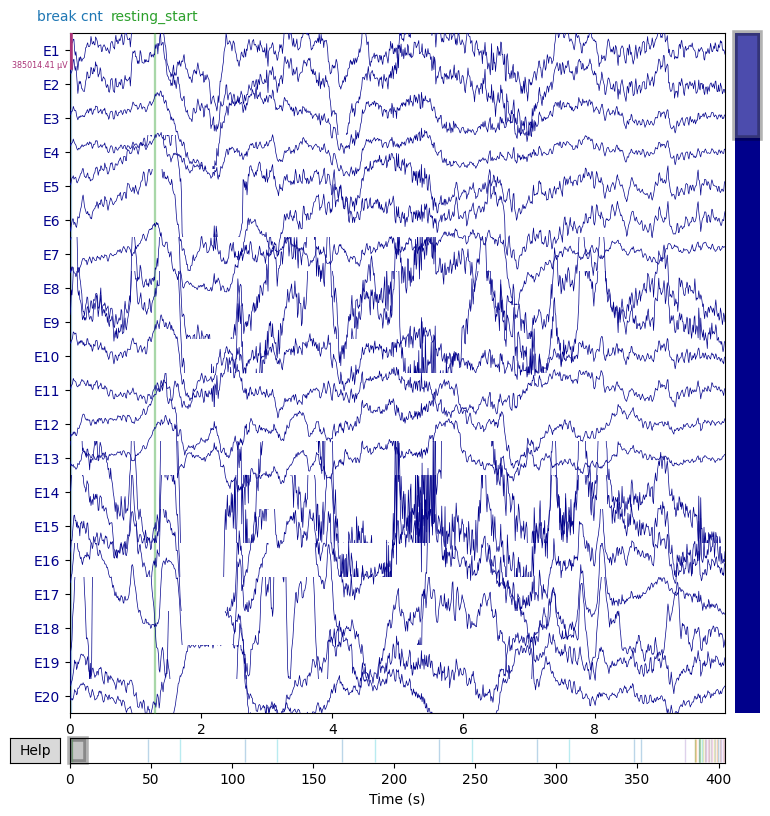

In [15]:
# --- 3. VISUALIZE: Interactive MNE Plot ---
# This opens an interactive window (zoom, scroll, pick channels)
print("\nOpening interactive MNE plot... (close to continue)")
first_raw.plot(
    n_channels=20,           # Show 20 channels at a time
    scalings='auto',         # Auto-scale (z-score → ~±3)
    duration=10,             # First 10 seconds
    color=dict(eeg='darkblue'),
    title=f"{description.get('task')} | {description.get('subject')} | Clean EEG",
    block=True               # Waits until you close the plot
)

plt.show()

### Creating the Fix length window for processing

In [16]:
from braindecode.preprocessing import create_fixed_length_windows

WINDOW_SEC = 30
SFREQ = 100.0
OVERLAP_RATIO = 0.5 # 50% overlap

window_size_samples = int(WINDOW_SEC * SFREQ)
window_stride_samples = int(window_size_samples * (1 - OVERLAP_RATIO))

print(f"Creating {WINDOW_SEC}-second windows with {OVERLAP_RATIO * 100}% overlap ")
windows_ds = create_fixed_length_windows(
    concat_ds = concat_preproc,
    start_offset_samples = 0,
    stop_offset_samples = None, 
    window_size_samples = window_size_samples,
    window_stride_samples = window_stride_samples,
    drop_last_window = False,
    preload = True,
)

print(f"Total JEPA windows: {len(windows_ds)}")
print(f"Window shape: {windows_ds[0][0].shape}")  # (1, 128, 3000)

Creating 30-second windows with 50.0% overlap 
Total JEPA windows: 4759
Window shape: (129, 3000)


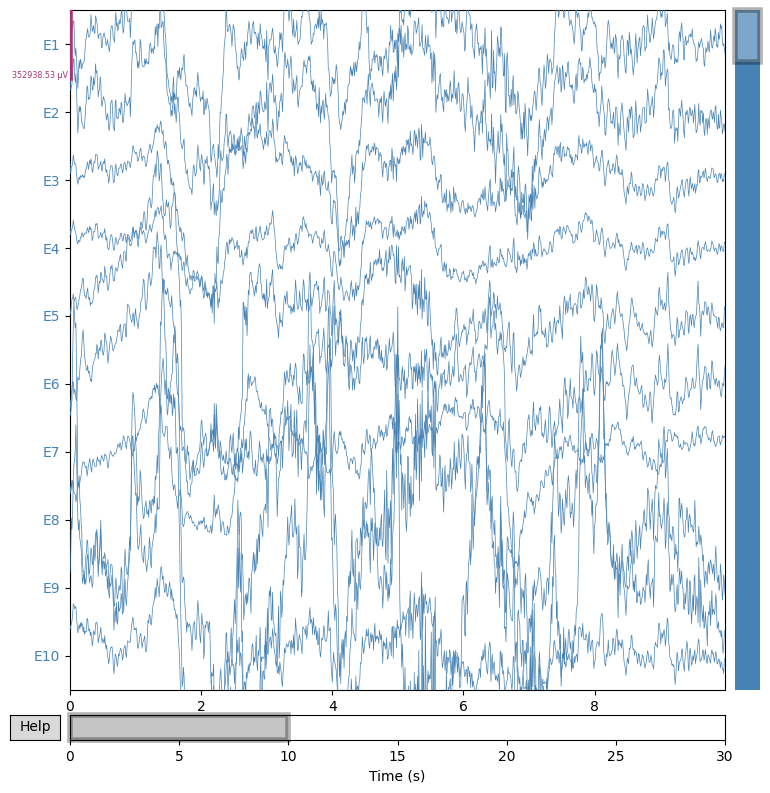

In [35]:
import mne
from mne.io import RawArray

# --- 1. Pick a window (e.g., index 42) ---
window_idx = 0
X, _, _ = windows_ds[window_idx]           # Shape: (128, 3000)
X_np = X

# 2. Build a temporary MNE Raw object
sfreq = 100.0
ch_names = windows_ds.datasets[window_idx].raw.ch_names
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
raw_win = RawArray(X_np, info, verbose=False)

# -------------------------------------------------
# 3. Add metadata to the title
# -------------------------------------------------
desc = windows_ds.datasets[window_idx].description
task   = desc.get('task', 'unknown')
subject = desc.get('subject', 'unknown')
i_start = desc.get('i_window_in_trial', 0) * 15   # 50 % overlap → 15 s stride
title = f'Window #{window_idx} | {task} | subj {subject} | {i_start:.0f}‑{i_start+30:.0f}s'

# -------------------------------------------------
# 4. Plot – identical to raw.plot()
# -------------------------------------------------
raw_win.plot(
    n_channels=10,          # show 30 channels at a time (scroll with mouse)
    scalings='auto',       # z‑score → ~±3 µV (auto works perfectly)
    title=title,
    color=dict(eeg='steelblue'),
    show_scrollbars=True,
    block=True,            # keeps the window open until you close it
    clipping=None,         # no clipping line (clean view)
)

plt.show()

In [39]:
# Run this on any window
X, _, _ = windows_ds[0]
raw = windows_ds.datasets[0].raw

print("Channel names (last 5):")
print(raw.ch_names[-5:])

print("\nChannel types (last 5):")
print(raw.get_channel_types()[-5:])

print(f"\nTotal channels: {len(raw.ch_names)}")

Channel names (last 5):
['E125', 'E126', 'E127', 'E128', 'Cz']

Channel types (last 5):
['eeg', 'eeg', 'eeg', 'eeg', 'eeg']

Total channels: 129


### Split into the train, valid, test

In [41]:
meta_information = windows_ds.get_metadata()
meta_information.head()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,task,subject,filename
0,0,0,3000,-1,RestingState,0,0-raw.fif
1,1,1500,4500,-1,RestingState,0,0-raw.fif
2,2,3000,6000,-1,RestingState,0,0-raw.fif
3,3,4500,7500,-1,RestingState,0,0-raw.fif
4,4,6000,9000,-1,RestingState,0,0-raw.fif


In [45]:
meta_information.iloc[2000: 2010]

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,task,subject,filename
11,11,16500,19500,-1,contrastChangeDetection,30,30-raw.fif
12,12,18000,21000,-1,contrastChangeDetection,30,30-raw.fif
13,13,19500,22500,-1,contrastChangeDetection,30,30-raw.fif
14,14,21000,24000,-1,contrastChangeDetection,30,30-raw.fif
15,15,22500,25500,-1,contrastChangeDetection,30,30-raw.fif
16,16,24000,27000,-1,contrastChangeDetection,30,30-raw.fif
17,17,25500,28500,-1,contrastChangeDetection,30,30-raw.fif
18,18,27000,30000,-1,contrastChangeDetection,30,30-raw.fif
19,19,28500,31500,-1,contrastChangeDetection,30,30-raw.fif
20,20,30000,33000,-1,contrastChangeDetection,30,30-raw.fif


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

subjects = meta_information["subject"].unique()

valid_frac = 0.1
test_frac = 0.1
seed = 2025

train_subj, valid_test_subject = train_test_split(
    subjects, test_size = (valid_frac + test_frac), 
    random_state = check_random_state(seed),
    shuffle = True
)

valid_subj, test_subj = train_test_split(
    valid_test_subject, test_size=test_frac, 
    random_state=check_random_state(seed + 1), shuffle=True
)


In [49]:
subject_split = windows_ds.split("subject")

train_set = []
valid_set = []
test_set = []

for s in subject_split:
    if s in train_subj:
        train_set.append(subject_split[s])
    elif s in valid_subj:
        valid_set.append(subject_split[s])
    elif s in test_subj:
        test_set.append(subject_split[s])

train_set = BaseConcatDataset(train_set)
valid_set = BaseConcatDataset(valid_set)
test_set = BaseConcatDataset(test_set)

print("Number of examples in each split in the minirelease")
print(f"Train:\t{len(train_set)}")
print(f"Valid:\t{len(valid_set)}")
print(f"Test:\t{len(test_set)}")

Number of examples in each split in the minirelease
Train:	3899
Valid:	688
Test:	172
